# PINN learning incompressible Navier-Stokes equations

The incompressible Navier-Stokes equations are

\begin{align}
    \partial_t \mathbf{v} + \lambda \mathbf{v} \cdot \nabla \mathbf{v} &= -\nabla p + \eta \nabla^2 \mathbf{v} \\
    \nabla \cdot \mathbf{v} &= 0
\end{align}

The second equation enfoces incompressibility.
Using data from the original PINN paper (see README), we can attempt to infer the parameters of this equation.
In the simulated dataset, $\lambda = 1$ (which is generally the case but we allow it to be learned as a test) and $\eta = 0.01$. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/cylinder_nektar_wake.mat')

U_star = data['U_star']
P_star = data['p_star']
t_star = data['t']
x_star = data['X_star']
print(x_star.shape, t_star.shape, U_star.shape, P_star.shape)

N = x_star.shape[0]
T = t_star.shape[0]

# Reshape data 
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
YY = np.tile(x_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

(5000, 2) (200, 1) (5000, 2, 200) (5000, 200)


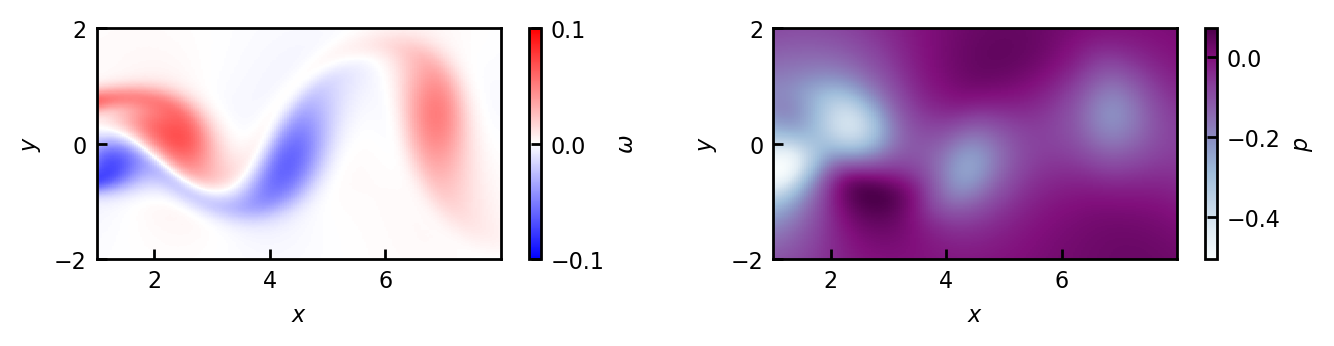

In [2]:
from scipy.interpolate import griddata

nn = 200
lb = x_star.min(0)
ub = x_star.max(0)
X, Y = np.meshgrid(
    np.linspace(lb[0], ub[0], nn),
    np.linspace(lb[1], ub[1], nn)
)

def plot_field(ax, u, v, p, vmin=-0.1, vmax=0.1, pmin=None, pmax=None):
    assert len(ax) == 2

    # Plot vorticity
    u_grid = griddata(x_star, u, (X, Y), method='cubic')
    v_grid = griddata(x_star, v, (X, Y), method='cubic')
    vort = np.gradient(u_grid, axis=0) - np.gradient(v_grid, axis=1)
    im = ax[0].pcolormesh(X, Y, vort, cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax[0], label='$\\omega$', ticks=[-0.1, 0, 0.1])

    # Plot pressure
    p_grid = griddata(x_star, p, (X, Y), method='cubic')
    im = ax[1].pcolormesh(X, Y, p_grid, cmap='BuPu', vmin=pmin, vmax=pmax)
    plt.colorbar(im, ax=ax[1], label='$p$')

    for a in ax:
        a.set(
            xlabel='$x$', xlim=[1, 8], xticks=[2, 4, 6],
            ylabel='$y$', ylim=[-2, 2], yticks=[-2, 0, 2],
            aspect='equal',
        )
    
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))
plot_field(ax, U_star[:, 0, 0], U_star[:, 1, 0], P_star[:, 0])

In [27]:
import torch
from navier_stokes_pinn import NavierStokesParameterPINN

# Training Data    
N_u = 20000
idx = np.random.choice(N*T, N_u, replace=False)
x_f = x[idx,:]
y_f = y[idx,:]
t_f = t[idx,:]
u_f = u[idx,:]
v_f = v[idx,:]


if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = NavierStokesParameterPINN(
    data=dict(
        x_f=x_f,
        y_f=y_f,
        t_f=t_f,
        u_f=u_f,
        v_f=v_f,
    ),
).to(device)
model.train(20000)

Starting to train on device cuda:0
Iteration 1000, Loss: 8.98230e-02, MSE: 8.92064e-02, Phys: 6.16613e-04
Iteration 2000, Loss: 4.09015e-03, MSE: 2.81413e-03, Phys: 1.27602e-03
Iteration 3000, Loss: 1.01962e-03, MSE: 6.57628e-04, Phys: 3.61992e-04
Iteration 4000, Loss: 4.39224e-04, MSE: 2.74137e-04, Phys: 1.65087e-04
Iteration 5000, Loss: 2.25095e-04, MSE: 1.29092e-04, Phys: 9.60035e-05
Iteration 6000, Loss: 1.48561e-04, MSE: 8.44248e-05, Phys: 6.41367e-05
Iteration 7000, Loss: 1.06827e-04, MSE: 6.04788e-05, Phys: 4.63483e-05
Iteration 8000, Loss: 8.19674e-05, MSE: 4.62497e-05, Phys: 3.57176e-05
Iteration 9000, Loss: 6.46661e-05, MSE: 3.65659e-05, Phys: 2.81002e-05
Iteration 10000, Loss: 5.20744e-05, MSE: 2.91704e-05, Phys: 2.29040e-05
Iteration 11000, Loss: 4.33049e-05, MSE: 2.41943e-05, Phys: 1.91106e-05
Iteration 12000, Loss: 3.66355e-05, MSE: 2.07677e-05, Phys: 1.58678e-05
Iteration 13000, Loss: 3.14926e-05, MSE: 1.82664e-05, Phys: 1.32261e-05
Iteration 14000, Loss: 2.76128e-05, MS

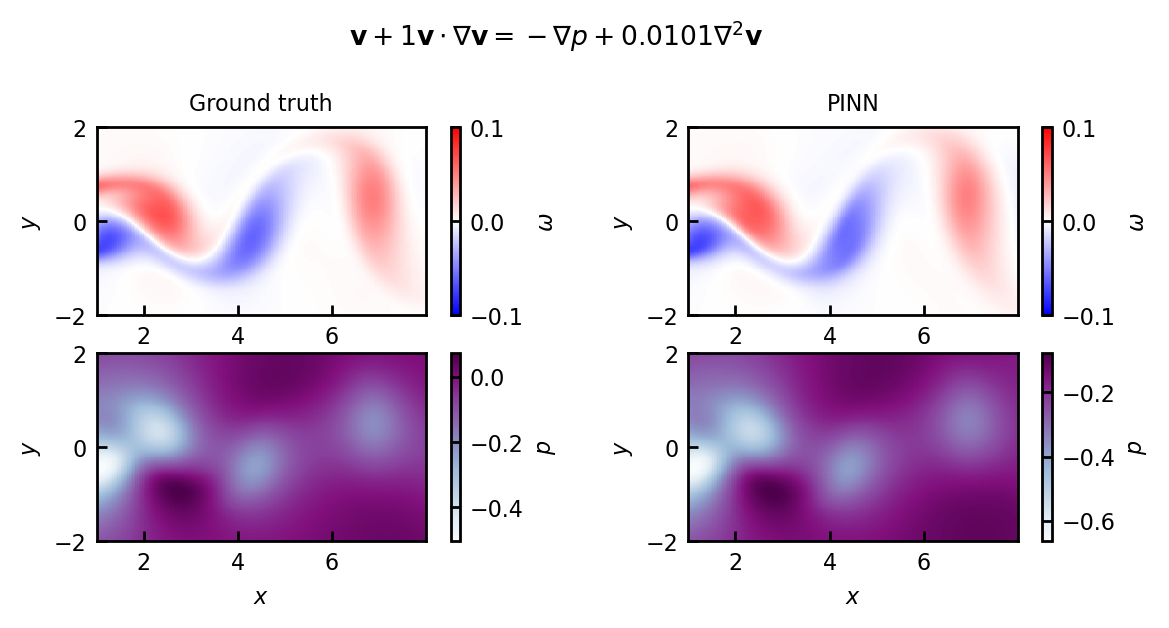

In [29]:
from scipy.interpolate import griddata
    
fig, ax = plt.subplots(2, 2, figsize=(7, 3))
plot_field(ax[:, 0], U_star[:, 0, 0], U_star[:, 1, 0], P_star[:, 0])
ax[0,0].set_title('Ground truth')

U_pred = model(torch.FloatTensor(np.concatenate([x,y,t], axis=-1)).to(device))
U_pred = U_pred.detach().cpu().numpy()
U_pred = U_pred.reshape([N, T, 3])
plot_field(ax[:, 1], U_pred[:, 0, 0], U_pred[:, 0, 1], U_pred[:, 0, 2])
ax[0,1].set_title('PINN')

fig.subplots_adjust(top=0.8)
lambda_1, lambda_2 = model.get_params()
lambda_1 = lambda_1.detach().item()
lambda_2 = lambda_2.detach().item()
eqn = f'$\\mathbf{{v}} + {lambda_1:.3g} \\mathbf{{v}} \\cdot \\nabla \\mathbf{{v}} = - \\nabla p + {lambda_2:.3g} \\nabla^2 \\mathbf{{v}}$'
fig.suptitle(eqn);